In [2]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from collections import defaultdict

foodSep = {'ACCESS':pd.DataFrame, 'STORES':pd.DataFrame, 'RESTAURANTS':pd.DataFrame,'ASSISTANCE':pd.DataFrame, 
        'INSECURITY':pd.DataFrame, 'PRICES_TAXES':pd.DataFrame,
        'LOCAL':pd.DataFrame, 'HEALTH':pd.DataFrame, 'SOCIOECONOMIC':pd.DataFrame}
for k, n in foodSep.items():
    foodSep[k] = pd.read_csv(k + '.csv')

/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [45]:
foodSep['ACCESS'].head()

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990


In [4]:
#combine all separate categories into one dataframe
# for simplicity. All categories have same number of rows
food = pd.concat(foodSep, axis=1)

In [5]:
#confirm combination
print(foodSep['ACCESS'].shape)
print(food.shape)
#things to investigate:
# sales to farmers
# food insecurity and very low food security
# adult diabetes and obesity rates

(3143, 44)
(3143, 304)


In [6]:
#replace empty rows, which according to doc are empty info
# with proper NaN so we can visualize how much info we're missing
for index, row in food.iterrows():
    for k, i in food.items():
        if food.loc[index, k] == "":
            food.loc[index, k] = NaN

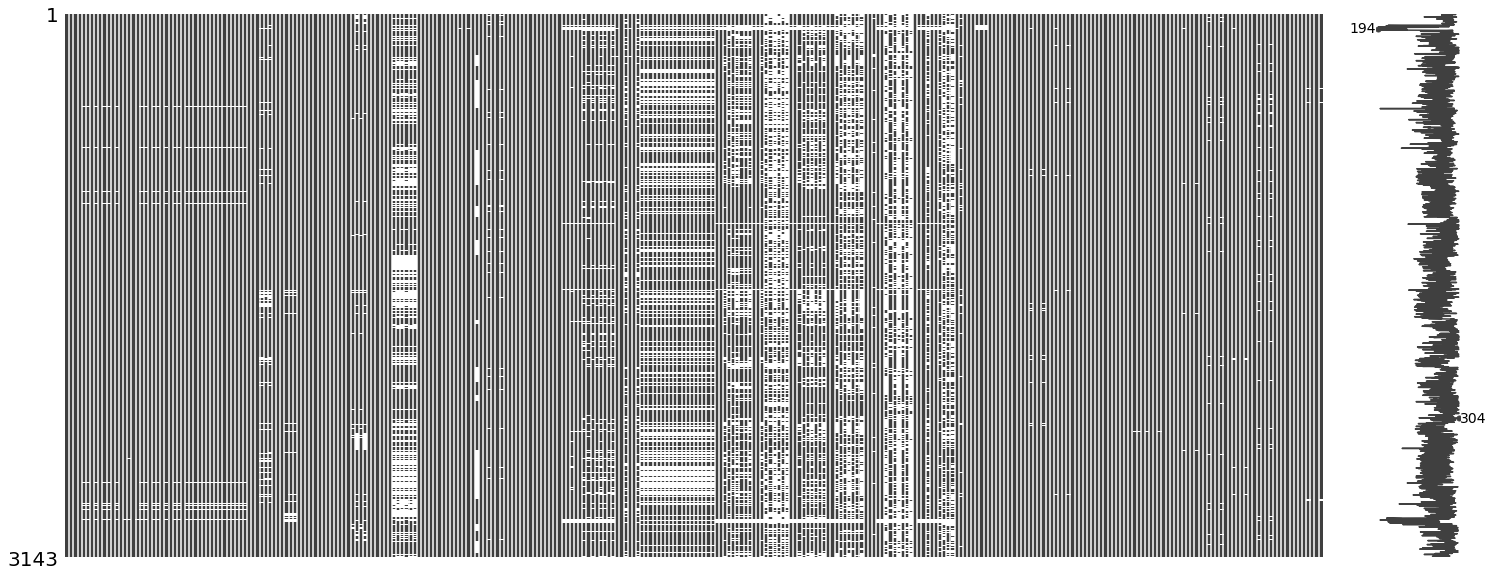

In [26]:
msno.matrix(food)

In [35]:
#Now that we see there's lots of info missing
# in some areas, lets find out which categories
# those areas correspond to
for k, i in food.items():
    print(k, sum(pd.isnull(food[k])))

('ACCESS', 'FIPS') 0
('ACCESS', 'State') 0
('ACCESS', 'County') 0
('ACCESS', 'LACCESS_POP10') 0
('ACCESS', 'LACCESS_POP15') 19
('ACCESS', 'PCH_LACCESS_POP_10_15') 26
('ACCESS', 'PCT_LACCESS_POP10') 0
('ACCESS', 'PCT_LACCESS_POP15') 19
('ACCESS', 'LACCESS_LOWI10') 0
('ACCESS', 'LACCESS_LOWI15') 20
('ACCESS', 'PCH_LACCESS_LOWI_10_15') 28
('ACCESS', 'PCT_LACCESS_LOWI10') 0
('ACCESS', 'PCT_LACCESS_LOWI15') 20
('ACCESS', 'LACCESS_HHNV10') 0
('ACCESS', 'LACCESS_HHNV15') 3
('ACCESS', 'PCH_LACCESS_HHNV_10_15') 14
('ACCESS', 'PCT_LACCESS_HHNV10') 0
('ACCESS', 'PCT_LACCESS_HHNV15') 3
('ACCESS', 'LACCESS_SNAP15') 20
('ACCESS', 'PCT_LACCESS_SNAP15') 20
('ACCESS', 'LACCESS_CHILD10') 0
('ACCESS', 'LACCESS_CHILD15') 19
('ACCESS', 'LACCESS_CHILD_10_15') 28
('ACCESS', 'PCT_LACCESS_CHILD10') 0
('ACCESS', 'PCT_LACCESS_CHILD15') 19
('ACCESS', 'LACCESS_SENIORS10') 0
('ACCESS', 'LACCESS_SENIORS15') 19
('ACCESS', 'PCH_LACCESS_SENIORS_10_15') 26
('ACCESS', 'PCT_LACCESS_SENIORS10') 0
('ACCESS', 'PCT_LACCESS_SE

In [17]:
#Lets remove categories which have too much missing information,
# here we removed all columns with more than 200 missing values
food_clean = food[[x[0] for x in food.items() if sum(pd.isnull(food[x[0]])) < 200]]
food_clean.shape

(3143, 224)

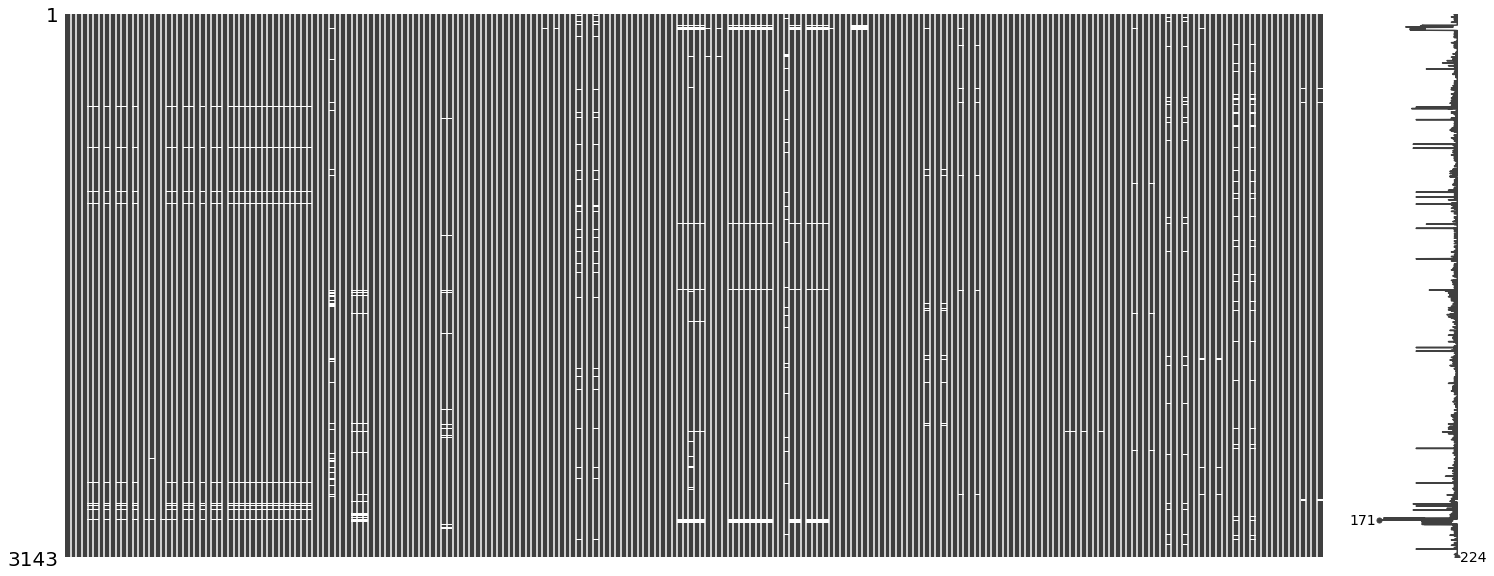

In [14]:
msno.matrix(food_clean)

In [36]:
# now lets remove rows with particularly large numbers of missing values
for i, row in food_clean.iterrows():
    if sum(pd.isnull(row)) > 40:
        food_clean = food_clean.drop(i)
print(food_clean.shape)
print(sum(sum(pd.isnull([food_clean[x[0]] for x in food_clean.items()]))))

(3068, 224)
2003


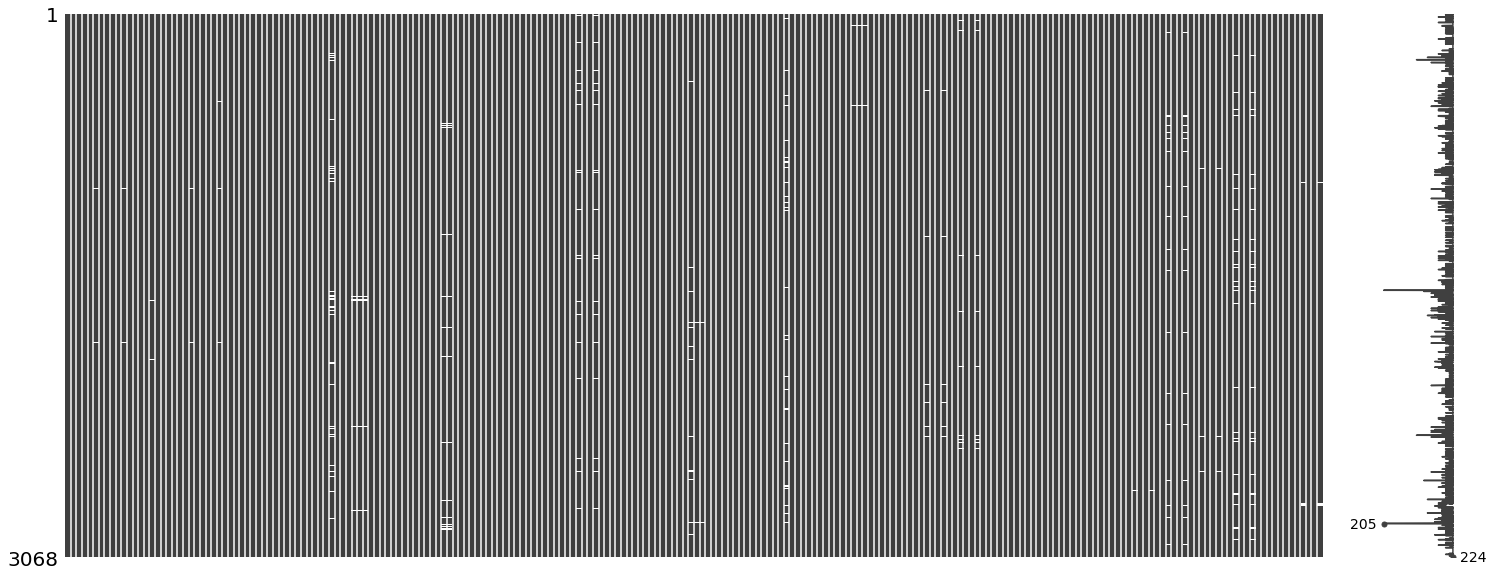

In [41]:
msno.matrix(food_clean)

In [65]:
#Replace missing values with average for category.
# logic is that since the missing values make up such a
# small part of the dataset (about .2%), it would not 
# skew the results too much, while still retaining a large
# amount of data that would have been lost had we simply removed 
# the entire rows

for index, (k, a) in enumerate(food_clean.items()):
    #skip over first three categories
    if sum(pd.isnull(a)) > 0 and index > 2:
        average = 0
        for ind, (num, val) in enumerate(a.items()):
            #Need to correct key index values because we dropped rows
            # (ex. [0:"foo", 1:'foo', 2:'foo'] >*drop item 1*> [0:'foo', 2:'foo'], <- need to correct)
            if ind != num:
                a[ind] = a.pop(num)
            if not pd.isnull(val):
                average += val # < for some reason this wont work
        average /= (len(a) - sum(pd.isnull(a)))
        for i in range(len(a)):
            if pd.isnull(a[i]):
                food_clean[k][i] = average

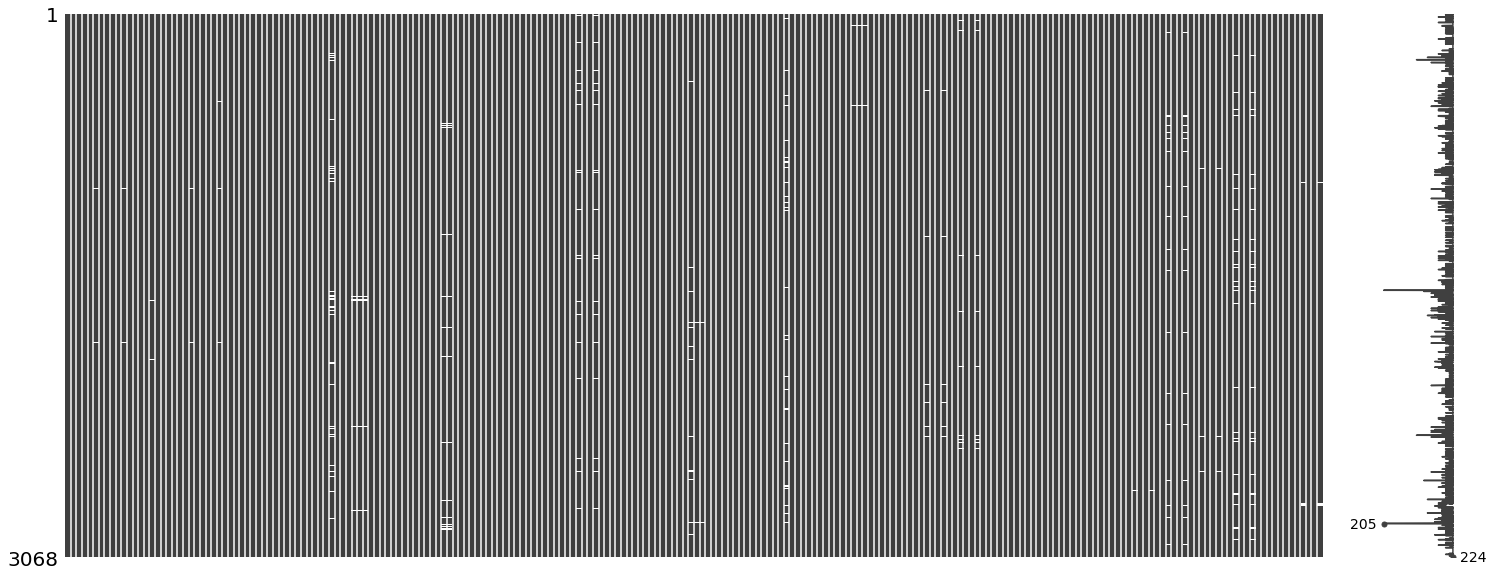

In [58]:
msno.matrix(food_clean)